# MLP

<img src='http://i.stack.imgur.com/3mnuT.png' />



## Notations

### Data

일반적인 분류문제에서 데이터는 다음 형태로 제공된다.  
$ \begin{align}
\mathscr{D} &= [ [\mathbf{x}^{(1)}, C^{(1)}], [\mathbf{x}^{(2)}, C^{(2)}], ... , [\mathbf{x}^{(N)}, C^{(N)}] ] \\
&= [\mathbf{x}^{(n)}, C^{(n)}]^{N}_{n=1}
\end{align} $

- input: $ \mathbf{x} = [x_1, x_2, ..., x_{N_i}] $  
- class: $ \mathcal{C} = \{C_1, C_2, ..., C_{N_k}\} $  
- target output: $ \mathbf{t} = [t_1, ..., t_{N_k}] $

 예)

|인구($x_1$) |면적($x_2$) |국명($C$)|
|-----------|-----------|--------|
|100000     |2000       |미국     |



예를 들어, 클래스가 {'미국', '중국', '일본'} 이라면,  
'미국'은 $ \mathbf{t} = [1, 0, 0] $  
'중국'은 $ \mathbf{t} = [0, 1, 0] $  
'일본'은 $ \mathbf{t} = [0, 0, 1] $  
으로 변환한다.

따라서 학습에 사용될 데이터 는 다음과 같이 변환한다.  
$ \mathscr{D} = [ [\mathbf{x}^{(1)}, \mathbf{t}^{(1)}], [\mathbf{x}^{(2)}, \mathbf{t}^{(2)}], ... , [\mathbf{x}^{(N)}, \mathbf{t}^{(N)}]  ] $  

### Neuron
For each neuron j,  

- output: $ o_j = \sigma(\mathtt{net}_j) $  
- activation function: $ \sigma(\cdot) $  
- weighted sum to neuron $j$: $\mathtt{net}_j = b_j + \sum_{i=1}^{N_i}{w_{ij}o_i}$  
- bias of neuron $j$: $b_j$  
- weight from neuron $i$ to neuron $j$: $w_{ij}$

### MLP

input: $ \mathbf{x} = [x_1, ..., x_i, ... , x_{N_i}] $  
hidden: $ \mathbf{h} = [h_1, ..., h_j, ... , h_{N_j}] $  
actual output: $ \mathbf{y} = [y_1, ..., y_k, ... , y_{N_k}] $  

$i$ : index for input neurons  
$j$ : index for hidden neurons  
$k$ : index for output neurons  

$h_j = \sigma(\mathtt{net}_j) = \sigma(b_j + \sum_{i=0}^{N_i}{w_{ij}x_i}) $  
$y_k = \sigma(\mathtt{net}_k) = \sigma(b_k + \sum_{j=0}^{N_j}{w_{jk}h_j}) $  

## Backpropagation

[Wikipedia](https://en.wikipedia.org/wiki/Backpropagation)  
[참고 1](http://galaxy.agh.edu.pl/~vlsi/AI/backp_t_en/backprop.html)  
[참고 2](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)  



In [1]:
%matplotlib inline

import numpy as np
from numpy import random
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cm 
from numpy.testing import assert_array_almost_equal as assertEqual

cmap = cm.RdBu

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return (1 - np.exp(-2 * x)) / (1 + np.exp(-2 * x))

def lin(x):
    return x

def ReLU(x):
    return np.maximum(0, x)



def grad_sigmoid(x, o=[]):
    if len(o) == 0:
        o = sigmoid(x)
        
    return np.multiply(o, (1 - o))

def grad_tanh(x, o=[]):
    if len(o) == 0:
        o = tanh(x)
        
    return 1 - np.power(o,2)

def grad_lin(x, o=[]):
    return 1

def grad_ReLU(x, o=[]):
    return x >= 0

In [3]:
class MLP(object):
    
    
    def __init__(self, nNeurons = [2, 4, 1], initW=0.1, actFns=[sigmoid, sigmoid], gradFns=[grad_sigmoid, grad_sigmoid]):
        self.nNeurons = nNeurons
        self.NumLayers = len(nNeurons) - 1
        self.W = []
        self.b = []
        for i in range(self.NumLayers):
            if initW == 0:
                self.W.append(np.zeros(nNeurons[i:i+2]))
            else:
                self.W.append((random.rand(nNeurons[i], nNeurons[i+1]) - 0.5) * 2 * initW)

            self.b.append(np.zeros(nNeurons[i+1]))
            
        if len(actFns) != self.NumLayers:
            raise  Exception('aaa')
            
        self.actFns = actFns
        self.gradFns = gradFns
        
        
    def evaluate(self, X):
        input = np.array(X) if type(X) is list else X
        
        nets = []
        outs = []
        
        input = X
        for i in range(self.NumLayers):
            net_i = self.b[i] + np.dot(input, self.W[i])
            out_i = self.actFns[i](net_i)
            
            nets.append(net_i)
            outs.append(out_i)
            
            input =  out_i
            
        return outs, nets

    def errors(self, X, t, outs=[]):
        _X = np.array(X) if type(X) is list else X
        _t = np.array(t) if type(t) is list else t
        
        if len(outs) == 0:
            outs, nets = self.evaluate(_X)
        
        errors = _t - outs[-1]
        
        return errors
        
    def lossFn(self, X, t):
        return 0.5 * np.sum(np.power(self.errors(X, t), 2))
            
    def grad(self, X, t, nets=[], outs=[], errors=[]):
        _X = np.array(X) if type(X) is list else X
        _t = np.array(t) if type(t) is list else t
        
        N, D = _X.shape
        
        if len(outs) == 0 or len(nets) == 0:
            outs, nets = self.evaluate(_X)
        
        if len(errors) == 0:
            errors = self.errors(_X, _t, outs)
            
        outs.insert(0, _X)
        nets.insert(0, _X)
        
        gradWs = []
        gradbs = []
        
        for i in reversed(range(self.NumLayers)):
            
            if i == self.NumLayers - 1:
                sumDelta = -1 * errors
            else:
                sumDelta = np.dot(delta, self.W[i+1].T)

            delta = np.multiply(sumDelta, self.gradFns[i](nets[i+1], o=outs[i+1]))
            
            gradWs.insert(0, np.dot(delta.T, outs[i]).T)
            gradbs.insert(0, np.sum(delta, 0))
            
        return gradWs, gradbs
        
    def update(self, gradWs, gradbs, mu):
        for i in range(len(self.W)):
            self.W[i] -= mu * gradWs[i]
            self.b[i] -= mu * gradbs[i]
        
testModel = MLP(nNeurons = [3, 5, 2], initW= 0.2, actFns=[ReLU, sigmoid], gradFns=[grad_ReLU, grad_sigmoid])
assertEqual(2, testModel.NumLayers)
assertEqual(2, len(testModel.W))
assertEqual([3,5], testModel.W[0].shape)
assertEqual([5,2], testModel.W[1].shape)
assert(np.all(0.0 < np.abs(testModel.W[0] < 0.2)))
assert(np.all(0.0 < np.abs(testModel.W[1] < 0.2)))
assertEqual(2, len(testModel.b))
assertEqual([5,], testModel.b[0].shape)
assertEqual([2,], testModel.b[1].shape)
assert(np.all(0.0 == np.abs(testModel.b[0])))
assert(np.all(0.0 == np.abs(testModel.b[1])))
assertEqual([0, 0, 1, 2], testModel.actFns[0]([-2, 0, 1, 2]))
assertEqual(0.5, testModel.actFns[1](0))

testModel = MLP(nNeurons = [3, 4, 2], initW= 0, actFns=[ReLU, sigmoid], gradFns=[grad_ReLU, grad_sigmoid])
testOut, testNet = testModel.evaluate(np.array([1,2,3]))
assertEqual(2, len(testOut))
assertEqual(np.zeros(4), testOut[0])
assertEqual(np.ones(2) * 0.5, testOut[1])
assertEqual(2, len(testNet))
assertEqual(np.zeros(4), testNet[0])
assertEqual(np.zeros(2), testNet[1])

testOut, testNet = testModel.evaluate([[1,2,3], [1,2,3]])
assertEqual(2, len(testOut))
assertEqual(np.zeros([2, 4]), testOut[0])
assertEqual(np.ones([2, 2]) * 0.5, testOut[1])
assertEqual(2, len(testNet))
assertEqual(np.zeros([2, 4]), testNet[0])
assertEqual(np.zeros([2, 2]), testNet[1])

assertEqual(np.array([.5, .5]), testModel.errors([0, 0, 0], [1, 1]))
assertEqual(np.array([[.5, .5],[.5, .5],[.5, -.5],[-.5, -.5]]), 
            testModel.errors([[0, 0, 0], [0, 0, 0], [0, 0, 0], [1,2,3]], [[1, 1], [1, 1], [1, 0], [0, 0]]))
assertEqual(0.5, testModel.lossFn([[0, 0, 0], [1,2,3]], [1, 0]))

# grad() 테스트
testModel = MLP(nNeurons = [3, 4, 2], initW= 0.1, actFns=[ReLU, sigmoid], gradFns=[grad_ReLU, grad_sigmoid])
testGW, testGb = testModel.grad([[0, 0, 0], [0, 0, 0], [1,2,3]], [[1, 0], [1, 0], [0, 1]])
assertEqual(testModel.W[0].shape, testGW[0].shape)
assertEqual(testModel.W[1].shape, testGW[1].shape)
assertEqual(testModel.b[0].shape, testGb[0].shape)
assertEqual(testModel.b[1].shape, testGb[1].shape)

N = 100
testX = random.randn(N, 3)
testY = random.randn(N, 2) > 0.5
testGW, testGb = testModel.grad(testX, testY)
h = 1e-3
(l, i, j) = (1, 2, 0)
testModel.W[l][i,j] += h
loss0 = testModel.lossFn(testX, testY)
testModel.W[l][i,j] -= 2*h
loss1 = testModel.lossFn(testX, testY)
assertEqual(testGW[l][i,j], (loss0 - loss1) / (2*h))

In [4]:
def plot_bi_data(x, y, title = u'',
                       markers = [u'x', u'o'], 
                       colors = ['r', 'b'], 
                       labels = [u'N', u'Y'],
                       ax = None):
    idx = [0, 0]
    
    classes = np.unique(y)
    
    for i in range(2):
        idx[i] = (np.where(y==classes[i])[0])
    
    if (ax == None):
        ax = plt.figure().add_subplot(111)
        
    for i in (1, 0):
        ax.plot(x[idx[i],0], x[idx[i],1], markers[i], 
                                          color=colors[i], 
                                          label= labels[i]) 
    ax.set_title(title)
    ax.legend()
    
    return ax

def plot_DecisionBoundary(x, clf, mlp):
    x0_min, x0_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x1_min, x1_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    
    h = 0.05
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))
    
    yy = clf(mlp, np.c_[xx0.ravel(), xx1.ravel()])
    yy = yy.reshape(xx0.shape)
    
    ax = plt.figure().add_subplot(111)
    ax.contourf(xx0, xx1, yy, cmap=cmap)
    
    return ax

def plot_GD(x, y, clf, mlp):
    ax = plot_DecisionBoundary(x, clf, mlp)
    ax = plot_bi_data(x, y, ax=ax)
    return ax

In [11]:
def classify(mlp, X):
    outs, nets = mlp.evaluate(X)
    out = outs[-1]
    
    c = np.ones(out.shape[0])
    c[out[:, 0] > out[:, 1]] = -1
    
    return c

def learn(mlp, x, y, epoch, mu):
    N, D = x.shape
    
    Y = np.array([y==0, y==1]).T
    
    for i in range(epoch):
        gradW, gradB = mlp.grad(x, Y)
        
        if (i % (epoch / 10) == 0):
            E = mlp.lossFn(x, Y)
            #print 'i = %d, E = %f' % (i, E)
            
            ax = plot_GD(x, y, classify, mlp)
            ax.set_title(u'i = %d, E = %f' % (i, E))
        mlp.update(gradW, gradB, mu)
    
    
    ax = plot_GD(x, y, classify, mlp)
    ax.set_title(u'i = %d, E = %f' % (epoch, E))

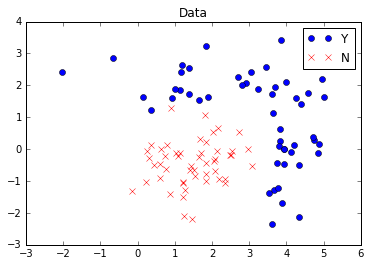

In [12]:
# Generate 2D data
N = 100

random.seed(5)

Yes = np.zeros([N/2, 2])
Yes1 = np.random.multivariate_normal([4, 0], [[0.3, 0], [0, 2]], N/4)
Yes2 = np.random.multivariate_normal([2, 2], [[2, 0], [0, 0.3]], N/4)
Yes[:N/4, :] = Yes1
Yes[N/4:, :] = Yes2

No = np.random.multivariate_normal([1.5, -0.5], [[0.5, 0], [0, 0.5]], N/2)

x = np.zeros([Yes.shape[0] + No.shape[0], 2])
x[:N/2, :2] = Yes
x[N/2:, :2] = No

y = np.append(np.ones(Yes.shape[0]),np.zeros(No.shape[0]))
    
plot_bi_data(x, y, title='Data')

training accuracy = 1.000000


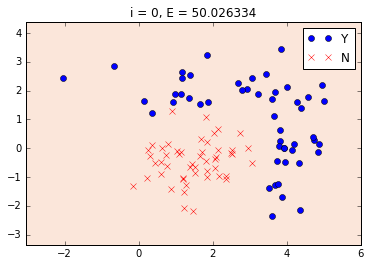

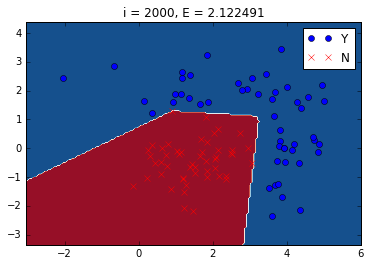

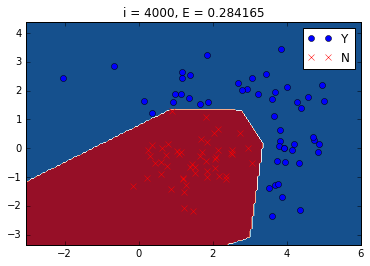

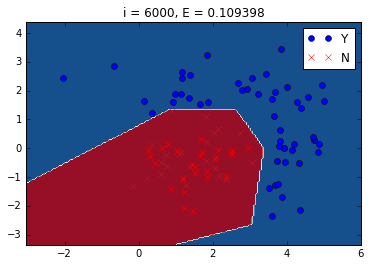

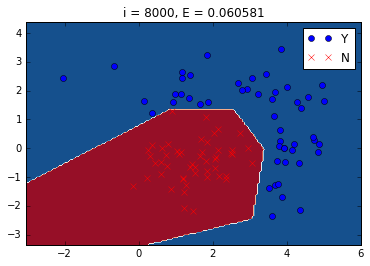

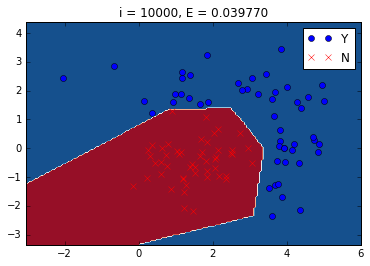

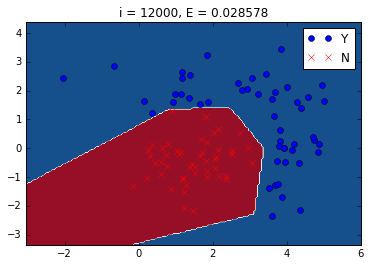

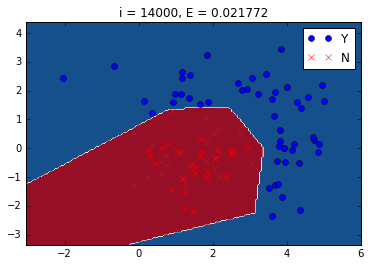

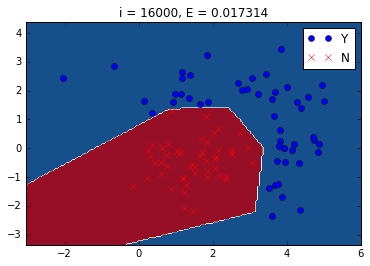

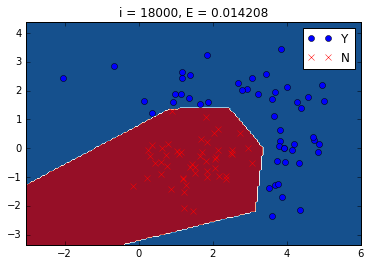

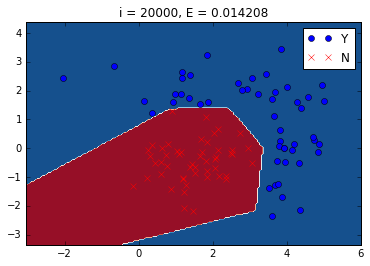

In [13]:
mlp = MLP(nNeurons = [2, 5, 5, 2], initW= 0.1, actFns=[ReLU, ReLU, tanh], gradFns=[grad_ReLU, grad_ReLU, grad_tanh])
learn(mlp, x, y, 20000, 0.001)
c = classify(mlp, x)
print "training accuracy = %f" % np.mean(y == (c>0))